In [1]:
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
import os
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer 


from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary

c:\Users\Jakub Machura\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # print(self.paths)
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        
    def find_classes(self,directory:str)->Tuple[list[str],dict[str,int]]:
        classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
        class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
        
        print(classes,class_to_idx)
        return classes,class_to_idx


In [3]:
class CustomDataTest():
    def __init__(self) -> None:

        self.train_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        self.test_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        """
            temp placement for of transform
        """
        self.train_transform=transforms.Compose([
            transforms.Resize(size=(64,64)),
            transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
        ])
    
        self.test_transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
        ])
    
        self.train_data_custom =ImageFolderCustom(self.train_dir,transform=self.train_transform)
        self.test_data_custom=ImageFolderCustom(self.test_dir,transform=self.test_transforms)
    
        """temp place for testing data"""    
        # Check for equality amongst our custom Dataset and ImageFolder Dataset
        # print((len(self.train_data_custom) == len(data.train_data)) & (len(self.test_data_custom) == len(data.test_data)))
        # print(self.train_data_custom.classes == data.train_data.classes)
        # print(self.train_data_custom.class_to_idx == data.train_data.class_to_idx)

        self.IntoDataLoaders()

    def IntoDataLoaders(self):
        BATCH_SIZE=32
        # NUM_WORKERS = os.cpu_count()
        NUM_WORKERS = 1

        # print(f"number of workers avalible {NUM_WORKERS}")
        self.train_dataloader= DataLoader(dataset=self.train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                    #  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

        self.test_dataloader = DataLoader(dataset=self.test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=NUM_WORKERS, 
                                    shuffle=False) # don't usually need to shuffle testing data

        img,label=next(iter(self.test_dataloader))
        # print(f"shape of custome dataloader img {img.shape}")

TinnyVGG with no regularization method applied

In [4]:
def train_step(model,loss_fn,optimizer,data):
        model.train()

        train_loss,train_acc=0, 0

        for batch, (X,y) in enumerate(data.train_dataloader):
            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            train_loss+=loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = y_logits.argmax(dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

        train_loss=train_loss/len(data.train_dataloader)
        train_acc=train_loss/len(data.train_dataloader)
        return train_loss,train_acc
    
def test_step(model,loss_fn,data:CustomDataTest):
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):

            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            test_pred_labels = y_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)
    return test_loss, test_acc

def Totrain(model,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,loss_fn,optimizer,data)
        test_loss,test_acc=test_step(model,loss_fn,data)
                # 4. Print out what's happening
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [5]:
class TinnyVGG(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    def ShapeCheck(self,data:CustomDataTest):
        img_batch,label_batch=next(iter(data.test_dataloader))

        img_single,label_single=img_batch[0].unsqueeze(dim=0), label_batch[0]
        
        # print(f"single img shape {img_single.shape}")

        self.eval()
        with torch.inference_mode():
            y=self(img_single)

        # print(f"shape of output raw y\n{y.shape}")
        # print(f"output of pred label \n{torch.argmax(torch.softmax(y,dim=1),dim=1)}")
        # print(f"actual label \n{label_single}")
    
    # def train_step(self,loss_fn,optimizer,data):
    #     self.train()

    #     train_loss,train_acc=0, 0

    #     for batch, (X,y) in enumerate(data.train_dataloader):
    #         y_logits=self(X)

    #         loss=loss_fn(y_logits,y)
    #         train_loss+=loss.item()

    #         optimizer.zero_grad()

    #         loss.backward()

    #         optimizer.step()

    #         y_pred_class = y_logits.argmax(dim=1)
    #         train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    #     train_loss=train_loss/len(data.train_dataloader)
    #     train_acc=train_loss/len(data.train_dataloader)
    #     return train_loss,train_acc
    
    # def test_step(self,loss_fn,data:CustomDataTest):
        
    #     self.eval()

    #     test_loss,test_acc=0,0

    #     with torch.inference_mode():
    #         for batch, (X,y) in enumerate(data.test_dataloader):
    #             y_logits=self(X)

    #             loss=loss_fn(y_logits,y)
    #             test_loss+=loss.item()

    #             test_pred_labels = y_logits.argmax(dim=1)
    #             test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    #     test_loss=test_loss/len(data.test_dataloader)
    #     test_acc=test_acc/len(data.test_dataloader)
    #     return test_loss, test_acc

    # def Totrain(self,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    #     self.results = {"train_loss": [],
    #     "train_acc": [],
    #     "test_loss": [],
    #     "test_acc": []
    # }
    

    #     for epoch in tqdm(range(epochs)):
    #         train_loss,train_acc=self.train_step(loss_fn,optimizer,data)

    #         test_loss,test_acc=self.test_step(loss_fn,data)

    #                 # 4. Print out what's happening
    #         print(
    #             f"Epoch: {epoch+1} | "
    #             f"train_loss: {train_loss:.4f} | "
    #             f"train_acc: {train_acc:.4f} | "
    #             f"test_loss: {test_loss:.4f} | "
    #             f"test_acc: {test_acc:.4f}"
    #         )
    
    #         # 5. Update results dictionary
    #         self.results["train_loss"].append(train_loss)
    #         self.results["train_acc"].append(train_acc)
    #         self.results["test_loss"].append(test_loss)
    #         self.results["test_acc"].append(test_acc)
        
    #     return self.results

In [6]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
<bound method Module.state_dict of TinnyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1280, out_features=3, bias=True)
  )
)>


  7%|▋         | 1/15 [00:00<00:13,  1.05it/s]

Epoch: 1 | train_loss: 1.1181 | train_acc: 0.1398 | test_loss: 1.1105 | test_acc: 0.2604


 13%|█▎        | 2/15 [00:01<00:10,  1.24it/s]

Epoch: 2 | train_loss: 1.1119 | train_acc: 0.1390 | test_loss: 1.1678 | test_acc: 0.1979


 20%|██        | 3/15 [00:02<00:09,  1.33it/s]

Epoch: 3 | train_loss: 1.0983 | train_acc: 0.1373 | test_loss: 1.1628 | test_acc: 0.2917


 27%|██▋       | 4/15 [00:03<00:07,  1.38it/s]

Epoch: 4 | train_loss: 1.0906 | train_acc: 0.1363 | test_loss: 1.1554 | test_acc: 0.1979


 33%|███▎      | 5/15 [00:03<00:07,  1.37it/s]

Epoch: 5 | train_loss: 1.1072 | train_acc: 0.1384 | test_loss: 1.1565 | test_acc: 0.1979


 40%|████      | 6/15 [00:04<00:06,  1.39it/s]

Epoch: 6 | train_loss: 1.1193 | train_acc: 0.1399 | test_loss: 1.1365 | test_acc: 0.2917


 47%|████▋     | 7/15 [00:05<00:05,  1.42it/s]

Epoch: 7 | train_loss: 1.1043 | train_acc: 0.1380 | test_loss: 1.0954 | test_acc: 0.2604


 53%|█████▎    | 8/15 [00:05<00:04,  1.41it/s]

Epoch: 8 | train_loss: 1.0975 | train_acc: 0.1372 | test_loss: 1.0979 | test_acc: 0.2083


 60%|██████    | 9/15 [00:06<00:04,  1.39it/s]

Epoch: 9 | train_loss: 1.0865 | train_acc: 0.1358 | test_loss: 1.1186 | test_acc: 0.1979


 67%|██████▋   | 10/15 [00:07<00:03,  1.38it/s]

Epoch: 10 | train_loss: 1.1106 | train_acc: 0.1388 | test_loss: 1.1455 | test_acc: 0.1979


 73%|███████▎  | 11/15 [00:08<00:02,  1.37it/s]

Epoch: 11 | train_loss: 1.0948 | train_acc: 0.1369 | test_loss: 1.1448 | test_acc: 0.1979


 80%|████████  | 12/15 [00:08<00:02,  1.37it/s]

Epoch: 12 | train_loss: 1.0913 | train_acc: 0.1364 | test_loss: 1.1433 | test_acc: 0.2917


 87%|████████▋ | 13/15 [00:09<00:01,  1.39it/s]

Epoch: 13 | train_loss: 1.0894 | train_acc: 0.1362 | test_loss: 1.1429 | test_acc: 0.3125


 93%|█████████▎| 14/15 [00:10<00:00,  1.40it/s]

Epoch: 14 | train_loss: 1.0900 | train_acc: 0.1362 | test_loss: 1.1441 | test_acc: 0.3125


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

Epoch: 15 | train_loss: 1.0687 | train_acc: 0.1336 | test_loss: 1.1404 | test_acc: 0.2917
Total training time: 10.922 seconds


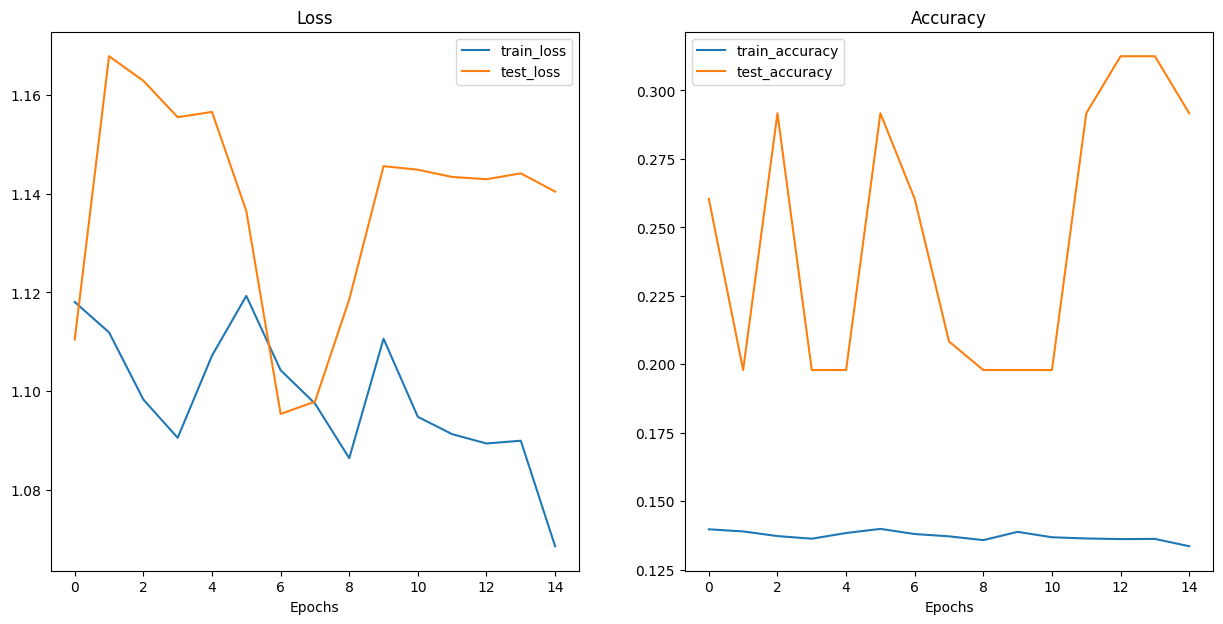

In [7]:

data1=CustomDataTest()
model0=TinnyVGG(3,len(data1.train_data_custom.classes),5)

model0_optimizer=torch.optim.Adam(params=model0.parameters(),lr=0.001)
model0_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model0_results=Totrain(model0,data=data1,epochs=15,optimizer=model0_optimizer,loss_fn=model0_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model0_results)

Model with 

In [8]:
class TinnyVGGNorm2D(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block1(x)))
    


<bound method Module.state_dict of TinnyVGGNorm2D(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)>


  2%|▏         | 1/50 [00:00<00:35,  1.39it/s]

Epoch: 1 | train_loss: 2.0056 | train_acc: 0.2507 | test_loss: 1.2428 | test_acc: 0.2917


  4%|▍         | 2/50 [00:01<00:32,  1.48it/s]

Epoch: 2 | train_loss: 1.4548 | train_acc: 0.1819 | test_loss: 1.5454 | test_acc: 0.2907


  6%|▌         | 3/50 [00:02<00:31,  1.48it/s]

Epoch: 3 | train_loss: 0.9975 | train_acc: 0.1247 | test_loss: 1.1519 | test_acc: 0.3835


  8%|▊         | 4/50 [00:02<00:31,  1.48it/s]

Epoch: 4 | train_loss: 0.9508 | train_acc: 0.1188 | test_loss: 1.4855 | test_acc: 0.3409


 10%|█         | 5/50 [00:03<00:30,  1.50it/s]

Epoch: 5 | train_loss: 1.0950 | train_acc: 0.1369 | test_loss: 1.0949 | test_acc: 0.4432


 12%|█▏        | 6/50 [00:04<00:29,  1.50it/s]

Epoch: 6 | train_loss: 0.8503 | train_acc: 0.1063 | test_loss: 1.4308 | test_acc: 0.3949


 14%|█▍        | 7/50 [00:04<00:28,  1.48it/s]

Epoch: 7 | train_loss: 0.9132 | train_acc: 0.1141 | test_loss: 1.2348 | test_acc: 0.4356


 16%|█▌        | 8/50 [00:05<00:27,  1.50it/s]

Epoch: 8 | train_loss: 0.8561 | train_acc: 0.1070 | test_loss: 1.2934 | test_acc: 0.4631


 18%|█▊        | 9/50 [00:06<00:27,  1.50it/s]

Epoch: 9 | train_loss: 0.8558 | train_acc: 0.1070 | test_loss: 1.7498 | test_acc: 0.3532


 20%|██        | 10/50 [00:06<00:26,  1.50it/s]

Epoch: 10 | train_loss: 0.8020 | train_acc: 0.1003 | test_loss: 0.9881 | test_acc: 0.5559


 22%|██▏       | 11/50 [00:07<00:25,  1.50it/s]

Epoch: 11 | train_loss: 0.7839 | train_acc: 0.0980 | test_loss: 1.4549 | test_acc: 0.3324


 24%|██▍       | 12/50 [00:08<00:25,  1.50it/s]

Epoch: 12 | train_loss: 0.7135 | train_acc: 0.0892 | test_loss: 1.4292 | test_acc: 0.3324


 26%|██▌       | 13/50 [00:08<00:24,  1.50it/s]

Epoch: 13 | train_loss: 0.6408 | train_acc: 0.0801 | test_loss: 1.2701 | test_acc: 0.4441


 28%|██▊       | 14/50 [00:09<00:23,  1.51it/s]

Epoch: 14 | train_loss: 1.0149 | train_acc: 0.1269 | test_loss: 1.3687 | test_acc: 0.3949


 30%|███       | 15/50 [00:10<00:23,  1.51it/s]

Epoch: 15 | train_loss: 0.6668 | train_acc: 0.0834 | test_loss: 1.0506 | test_acc: 0.4640


 32%|███▏      | 16/50 [00:10<00:22,  1.52it/s]

Epoch: 16 | train_loss: 0.8828 | train_acc: 0.1103 | test_loss: 1.7710 | test_acc: 0.3845


 34%|███▍      | 17/50 [00:11<00:22,  1.50it/s]

Epoch: 17 | train_loss: 0.7402 | train_acc: 0.0925 | test_loss: 1.1040 | test_acc: 0.5142


 36%|███▌      | 18/50 [00:12<00:21,  1.51it/s]

Epoch: 18 | train_loss: 0.7058 | train_acc: 0.0882 | test_loss: 1.5909 | test_acc: 0.3741


 38%|███▊      | 19/50 [00:12<00:20,  1.53it/s]

Epoch: 19 | train_loss: 0.7933 | train_acc: 0.0992 | test_loss: 1.0806 | test_acc: 0.5152


 40%|████      | 20/50 [00:13<00:19,  1.53it/s]

Epoch: 20 | train_loss: 0.6930 | train_acc: 0.0866 | test_loss: 1.4675 | test_acc: 0.4138


 42%|████▏     | 21/50 [00:13<00:18,  1.54it/s]

Epoch: 21 | train_loss: 0.9855 | train_acc: 0.1232 | test_loss: 1.4179 | test_acc: 0.3627


 44%|████▍     | 22/50 [00:14<00:18,  1.55it/s]

Epoch: 22 | train_loss: 0.8866 | train_acc: 0.1108 | test_loss: 1.4178 | test_acc: 0.3324


 46%|████▌     | 23/50 [00:15<00:17,  1.56it/s]

Epoch: 23 | train_loss: 0.6833 | train_acc: 0.0854 | test_loss: 1.1237 | test_acc: 0.4328


 48%|████▊     | 24/50 [00:15<00:16,  1.56it/s]

Epoch: 24 | train_loss: 1.1284 | train_acc: 0.1410 | test_loss: 1.8093 | test_acc: 0.3229


 50%|█████     | 25/50 [00:16<00:16,  1.55it/s]

Epoch: 25 | train_loss: 0.9926 | train_acc: 0.1241 | test_loss: 1.1473 | test_acc: 0.4432


 52%|█████▏    | 26/50 [00:17<00:15,  1.54it/s]

Epoch: 26 | train_loss: 0.9593 | train_acc: 0.1199 | test_loss: 1.3005 | test_acc: 0.3636


 54%|█████▍    | 27/50 [00:17<00:14,  1.55it/s]

Epoch: 27 | train_loss: 0.7855 | train_acc: 0.0982 | test_loss: 1.2427 | test_acc: 0.5256


 56%|█████▌    | 28/50 [00:18<00:14,  1.55it/s]

Epoch: 28 | train_loss: 0.8099 | train_acc: 0.1012 | test_loss: 1.3890 | test_acc: 0.4138


 58%|█████▊    | 29/50 [00:19<00:13,  1.55it/s]

Epoch: 29 | train_loss: 0.5943 | train_acc: 0.0743 | test_loss: 1.3862 | test_acc: 0.4545


 60%|██████    | 30/50 [00:19<00:12,  1.54it/s]

Epoch: 30 | train_loss: 0.5842 | train_acc: 0.0730 | test_loss: 1.2490 | test_acc: 0.4242


 62%|██████▏   | 31/50 [00:20<00:12,  1.55it/s]

Epoch: 31 | train_loss: 0.4411 | train_acc: 0.0551 | test_loss: 1.0992 | test_acc: 0.5161


 64%|██████▍   | 32/50 [00:21<00:11,  1.55it/s]

Epoch: 32 | train_loss: 0.4423 | train_acc: 0.0553 | test_loss: 1.2314 | test_acc: 0.4138


 66%|██████▌   | 33/50 [00:21<00:10,  1.55it/s]

Epoch: 33 | train_loss: 0.4150 | train_acc: 0.0519 | test_loss: 1.0953 | test_acc: 0.5360


 68%|██████▊   | 34/50 [00:22<00:10,  1.56it/s]

Epoch: 34 | train_loss: 0.8605 | train_acc: 0.1076 | test_loss: 1.3413 | test_acc: 0.3627


 70%|███████   | 35/50 [00:22<00:09,  1.57it/s]

Epoch: 35 | train_loss: 0.6554 | train_acc: 0.0819 | test_loss: 1.1623 | test_acc: 0.5152


 72%|███████▏  | 36/50 [00:23<00:08,  1.57it/s]

Epoch: 36 | train_loss: 0.5809 | train_acc: 0.0726 | test_loss: 1.2005 | test_acc: 0.4754


 74%|███████▍  | 37/50 [00:24<00:08,  1.58it/s]

Epoch: 37 | train_loss: 0.5546 | train_acc: 0.0693 | test_loss: 0.9975 | test_acc: 0.5871


 76%|███████▌  | 38/50 [00:24<00:07,  1.57it/s]

Epoch: 38 | train_loss: 0.5757 | train_acc: 0.0720 | test_loss: 1.4545 | test_acc: 0.3939


 78%|███████▊  | 39/50 [00:25<00:07,  1.57it/s]

Epoch: 39 | train_loss: 0.5832 | train_acc: 0.0729 | test_loss: 1.2111 | test_acc: 0.4034


 80%|████████  | 40/50 [00:26<00:06,  1.56it/s]

Epoch: 40 | train_loss: 0.4820 | train_acc: 0.0603 | test_loss: 1.2094 | test_acc: 0.4545


 82%|████████▏ | 41/50 [00:26<00:05,  1.55it/s]

Epoch: 41 | train_loss: 0.4159 | train_acc: 0.0520 | test_loss: 1.1384 | test_acc: 0.4848


 84%|████████▍ | 42/50 [00:27<00:05,  1.57it/s]

Epoch: 42 | train_loss: 0.4411 | train_acc: 0.0551 | test_loss: 1.0973 | test_acc: 0.4848


 86%|████████▌ | 43/50 [00:28<00:04,  1.56it/s]

Epoch: 43 | train_loss: 0.5204 | train_acc: 0.0651 | test_loss: 1.4734 | test_acc: 0.3210


 88%|████████▊ | 44/50 [00:28<00:03,  1.57it/s]

Epoch: 44 | train_loss: 0.5416 | train_acc: 0.0677 | test_loss: 1.0202 | test_acc: 0.5549


 90%|█████████ | 45/50 [00:29<00:03,  1.56it/s]

Epoch: 45 | train_loss: 0.5265 | train_acc: 0.0658 | test_loss: 1.2551 | test_acc: 0.3617


 92%|█████████▏| 46/50 [00:29<00:02,  1.56it/s]

Epoch: 46 | train_loss: 0.6229 | train_acc: 0.0779 | test_loss: 1.0641 | test_acc: 0.5038


 94%|█████████▍| 47/50 [00:30<00:01,  1.52it/s]

Epoch: 47 | train_loss: 0.4336 | train_acc: 0.0542 | test_loss: 1.2504 | test_acc: 0.4034


 96%|█████████▌| 48/50 [00:31<00:01,  1.49it/s]

Epoch: 48 | train_loss: 0.5337 | train_acc: 0.0667 | test_loss: 1.1385 | test_acc: 0.5663


 98%|█████████▊| 49/50 [00:32<00:00,  1.46it/s]

Epoch: 49 | train_loss: 0.4802 | train_acc: 0.0600 | test_loss: 1.1926 | test_acc: 0.4129


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]

Epoch: 50 | train_loss: 0.4771 | train_acc: 0.0596 | test_loss: 1.2066 | test_acc: 0.4337
Total training time: 32.817 seconds


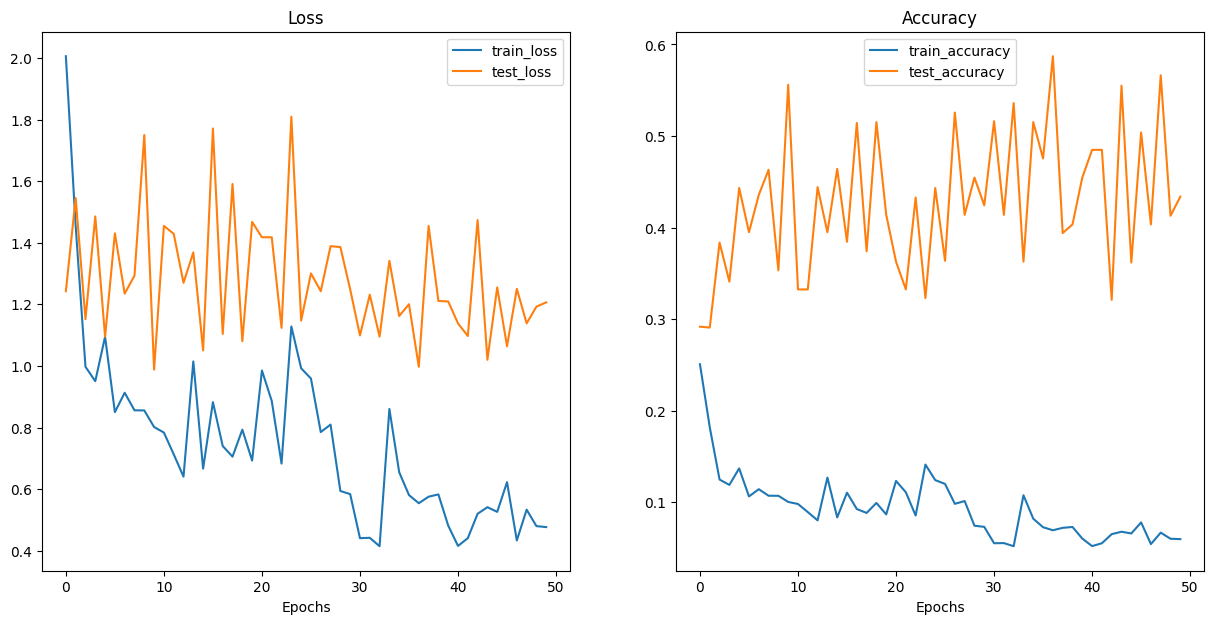

In [9]:
model1=TinnyVGGNorm2D(3,len(data1.train_data_custom.classes),5)

model1_optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.001)
model1_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model1_results=Totrain(model1,data=data1,epochs=50,optimizer=model1_optimizer,loss_fn=model1_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model1_results)

Testing usage of BlockDrop on TinnyVGG with InstanceNorm2d regularization 
BlockDrop class 

In [10]:

class BlockDrop(nn.Module):
    def __init__(self, block, p=0.5):
        super(BlockDrop, self).__init__()
        self.block = block
        self.p = p

    def forward(self, x):
        if self.training:
            return self.block(x) if torch.rand(1) > self.p else x
        return self.block(x)

class TinnyVGGBlockDrop(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=BlockDrop(nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ))
        self.conv_block_2 = BlockDrop(nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ))
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    
   


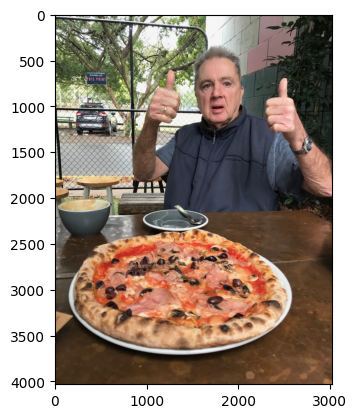

In [12]:
import torchvision
custom_img_path="C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\04-pizza-dad.jpeg"
custom_img_unit8=torchvision.io.read_image(str(custom_img_path))

# torch.Size([3, 4032, 3024])
custom_img_unit8.shape
# torch.uint8
custom_img_unit8.dtype

custom_image=custom_img_unit8=torchvision.io.read_image(str(custom_img_path)).type(torch.float32)
# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 
# torch.float32
custom_image.dtype


plt.imshow(custom_image.permute(1,2,0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error

custom_img_transform=transforms.Compose([
    transforms.Resize((64,64)),
])

custom_image_transformed=custom_img_transform(custom_image) 

custom_image_transformed.shape

model1.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size=custom_image_transformed.unsqueeze(dim=0)

    custom_img_pred=model1(custom_image_transformed_with_batch_size)
